# Training Load and Recovery Time Model

## Purpose

The purpose of this document is to use the existing data to calculate **Recovery Time** and **Training Readiness** after each training session. The model will use metrics like Training Load (TL), Chronic Training Load (CTL), Acute Training Load (ATL), Sleep Score, Heart Rate Variability (HRV), and VO2 Max to estimate recovery needs and readiness to continue training.

## Methodology

To achieve the outcome of predicting recovery time and training readiness, we will follow a series of steps, including:
1. Generating new sleep efficiency and hrv data.
2. Applying hypothetical calculations and existing scientific formulas to derive the necessary metrics for recovery.
3. Integrating concepts from research on **Garmin’s recovery models**, **EPOC-based training load**, and other performance-based insights.

### A. Training Load

Training Load is calculated using the following components:

1. **Intensity**: Intensity is the ratio of **average heart rate** to **maximum heart rate**:
   
   $ =\text{Intensity} = \frac{\text{Average Heart Rate}}{\text{Max Heart Rate}} \times 100$
   
   
2. **Training Load (TL)**: Training Load is calculated as the product of **intensity** and **duration** of the session:
   
   $= \text{Training Load} = \text{Intensity} \times \text{Duration (minutes)}$
   

3. **Chronic Training Load (CTL)**: CTL represents the long-term training load and is calculated using an exponentially weighted moving average (EWMA) over a 28-day period:
   
   $=\text{CTL} = \text{EWMA}_{28d}(\text{Training Load})$
   

4. **Acute Training Load (ATL)**: ATL represents the short-term load over the last 7 days, calculated similarly with a 7-day exponentially weighted average:
   
   $=\text{ATL} = \text{EWMA}_{7d}(\text{Training Load})$
   

5. **Training Stress Balance (TSB)**: TSB measures the balance between CTL and ATL, indicating fitness vs. fatigue:
   
   $=\text{TSB} = \text{CTL} - \text{ATL}$
   

### B. Recovery Time

1. **Sleep Data**: The sleep data used includes the following newly generated columns from a Kaggle dataset:
   - **Bedtime**
   - **Wakeup Time**
   - **Sleep Duration**
   - **Sleep Efficiency**
   - **REM Sleep Percentage**


2. **Sleep Score Calculation**: The Sleep Score is derived based on sleep duration, efficiency, and the percentage of REM and Light sleep. It is calculated using the following formula:
   
   $= \text{Sleep Score} = \left( \frac{\text{Sleep Duration}}{8} \times 0.4 \right) + \left( \frac{\text{REM Sleep Percentage}}{100} \times 0.3 \right) + \left( \frac{\text{Sleep Efficiency}}{100} \times 0.3 \right)$
   
   This formula gives weight to different sleep factors, aiming for an optimal score of 100.

3. **HRV Data**: HRV data is generated randomly based on typical values for male athletes. For instance, HRV values between 50 and 100 ms are commonly seen, with higher values indicating better recovery.

4. **EPOC Calculation**: EPOC is the **Excess Post-Exercise Oxygen Consumption**, which helps in estimating the recovery time. It is calculated using the following formula:
   
   $= \text{EPOC} = \text{Intensity} \times \text{Duration (minutes)} \times \text{Body Weight (kg)}$
   

5. **VO2 Max Calculation**: VO2 Max is estimated using the formula based on the **maximum heart rate (Max HR)** and **resting heart rate (Rest HR)**:
   
   $=\text{VO2 Max} = 15.3 \times \left( \frac{\text{Max HR}}{\text{Rest HR}} \right)$
   
   The **Rest HR** is assumed to be the **minimum heart rate** observed during each activity minus 15 bpm:
   
   $=\text{Rest HR} = \text{Min HR} - 15$
   

6. **Baseline Recovery Time Calculation**: Baseline recovery time is derived based on the EPOC from each training session. A simple formula to estimate recovery time (in hours) is:
   
   $=\text{Baseline Recovery Time (hours)} = \frac{\text{EPOC}}{100}$
   
   The factor of 100 can be adjusted based on the intensity and type of sport.

7. **Final Recovery Time Calculation**: The final recovery time combines training metrics, sleep data, and HRV to give a personalized recovery recommendation. The formula is:
   
   $= \text{Recovery Time (hours)} = \text{Baseline Recovery Time} \times \left(1 + \alpha \times \text{AC Ratio}\right) \times \left(1 + \beta \times \frac{1}{\text{Sleep Score}}\right) \times \left(1 + \gamma \times \frac{\text{HRV}}{100}\right) \times \left(1 - \delta \times \frac{\text{VO2 Max}}{100}\right)$
   
   Where:
   - **AC Ratio** is the acute-to-chronic training load ratio. Higher current load to normal load will lead to longer recovery time.
   - **Sleep Score** measures sleep quality. Lower sleep score indicating longer recovery time.
   - **HRV**: inverse factor, higher HRV will shorten recovery time.
   - **VO2 Max** affects recovery, with higher values leading to shorter recovery times.

### C. Training Readiness

Training Readiness is calculated several key factors such as **Chronic Training Load (CTL)**, **Acute Training Load (ATL)**, **Sleep Score**, **Heart Rate Variability (HRV)**, and **VO2 Max**. 

The formula for calculating Training Readiness is similar to that used for Recovery Time but focuses on the athlete’s ability to handle more intense training sessions. A higher **Training Readiness score** suggests that the athlete is well-recovered and can perform at a high level, while a lower score indicates fatigue or poor recovery.

The formula used to calculate Training Readiness is as follows:


$=\text{Training Readiness} = f(\text{CTL}, \text{ATL}, \text{Training Load}, \text{Sleep Score}, \text{HRV}, \text{TSB})$


Where:
- **CTL** and **ATL** are for long-term and short-term training loads.
- **Sleep Score** and **HRV** reflect recovery quality.
- **TSB (Training Stress Balance)** represents the difference between fitness and fatigue, calculated as **TSB = CTL - ATL**.


With these steps and calculations, we aim to provide accurate and data-driven estimates of recovery time and training readiness for each session.


In [1]:
import pandas as pd

import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Get the current working directory
current_dir = os.getcwd()

# Parent Directory
parent_dir = os.path.dirname(current_dir)

# Running_Archive path
Running_archive_dir = os.path.join(parent_dir, 'Running_Archive')

# Working file
file_path = os.path.join(Running_archive_dir, 'fixed_cleaned_activities.csv')

# Load the data
df = pd.read_csv(file_path)



#### Sleep score

In [ ]:
sleep_df = pd.read_csv('Sleep_Efficiency.csv')

sleep_df.info()

In [ ]:
# Randomly select 155 rows from relevant columns
sleep_df_selected = sleep_df[['Sleep duration', 'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage']]

sleep_df_sampled = sleep_df_selected.dropna().sample(n=155, random_state=42)

# Sleep score calculation 
sleep_df_sampled['Sleep score'] = (
    (sleep_df_sampled['Sleep duration'] / 8 * 0.4) +
    (sleep_df_sampled['REM sleep percentage'] / 100 * 0.3) +
    (sleep_df_sampled['Sleep efficiency'] / 100 * 0.3)
)

print(sleep_df_sampled['Sleep score'])

In [ ]:
# Add sleep score to main df
df['Sleep score'] = sleep_df_sampled['Sleep score'].values


#### Training Load

In [ ]:
# Convert duration to total minutes
df['Duration (Minutes)'] = pd.to_timedelta(df['Duration (h:m:s)']).dt.total_seconds() / 60

# Calculate Intensity as a percentage of Max Heart Rate
df['Intensity'] = (df['Average Heart Rate (bpm)'] / df['Max. Heart Rate (bpm)']) * 100

# Calculate Training Load
df['Training Load'] = df['Intensity'] * df['Duration (Minutes)']


#### Chronic Training Load (CTL), Acute Training Load (ATL), and Training Stress Balance (TSB)


In [15]:
# Correct date format
df['Date'] = pd.to_datetime(df['Begin Timestamp'], format="%d/%m/%Y %H:%M").dt.date

# Aggregate daily Training Load
daily_tl = df.groupby('Date')['Training Load'].sum().reset_index()


# Calculate CTL using EWMA
daily_tl['CTL'] = daily_tl['Training Load'].ewm(span=28, adjust=False).mean()

# Calculate ATL 
daily_tl['ATL'] = daily_tl['Training Load'].ewm(span=7, adjust=False).mean()

# Calculate TSB
daily_tl['TSB'] = daily_tl['CTL'] - daily_tl['ATL']


df['CTL'] = daily_tl['CTL']
df['ATL'] = daily_tl['ATL']
df['TSB'] = daily_tl['TSB']



In [ ]:
print(df[['Activity ID', 'Duration (Minutes)', 'Intensity', 'Training Load','CTL','ATL','TSB']].head(10))


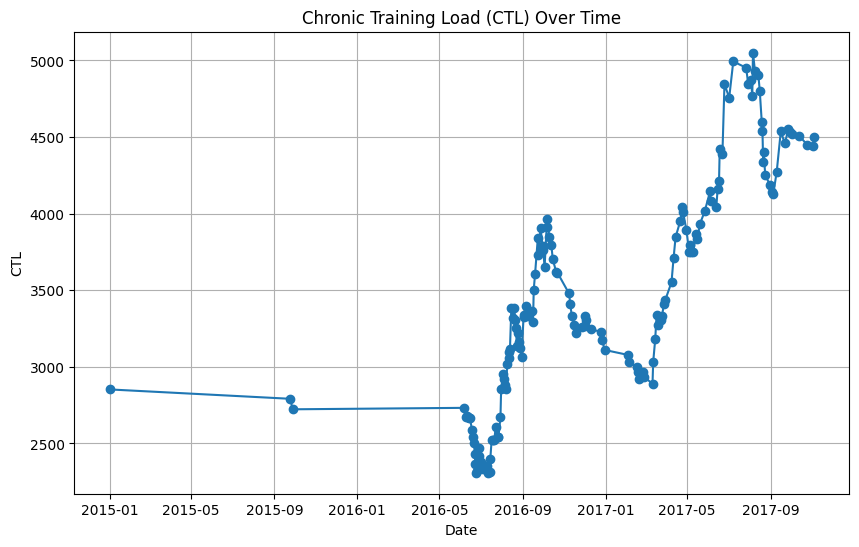

In [19]:
import matplotlib.pyplot as plt

# Plot the CTL over time
plt.figure(figsize=(10, 6))
plt.plot(daily_tl['Date'], daily_tl['CTL'], marker='o')
plt.title('Chronic Training Load (CTL) Over Time')
plt.xlabel('Date')
plt.ylabel('CTL')
plt.grid(True)
plt.show()


#### HRV

In [20]:
import numpy as np
np.random.seed(42) 
df['HRV (ms)'] = np.random.normal(loc=70, scale=10, size=len(df))  # Mean HRV ~ 70 ms, std dev ~ 10 ms


#### VO2 Max

In [23]:
df['Resting HR (bpm)'] = df['Min. Heart Rate (bpm)'] - 15



df['VO2 Max'] = 15.3 * (df['Max. Heart Rate (bpm)'] / df['Resting HR (bpm)'])


#### EPOC

In [22]:
# Set body weight
body_weight = 80  # kg
df['EPOC'] = df['Intensity'] * df['Duration (Minutes)'] * body_weight


#### Recovery Time

In [ ]:
# Calculate AC Ratio (ATL/CTL)
df['AC Ratio'] = df['ATL'] / df['CTL']
df[['EPOC', 'AC Ratio', 'Sleep score', 'HRV (ms)', 'VO2 Max']].head()


We need to normalize these values so they are in the same range for the calculation of Recovery time.

In [ ]:
# Normalize all values
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df['AC_norm'] = normalize(df['AC Ratio'])
df['Sleep_norm'] = normalize(df['Sleep score'])
df['HRV_norm'] = normalize(df['HRV (ms)'])
df['VO2 Max_norm'] = normalize(df['VO2 Max'])

# Display the normalized values
df[['AC_norm', 'Sleep_norm', 'HRV_norm', 'VO2 Max_norm']].head()


In [ ]:
# Calculate Recovery time
# Weighting factors (Can be adjusted later)
alpha = 0.4  # AC Ratio
beta = 0.3   # Sleep Score
gamma = 0.15  # HRV
delta = 0.15   # VO2 Max

# BAseline recovery time (in hours)
epoc = df['EPOC']
baseline_recovery_time = epoc/100/60 
# Calculate Recovery Time
Recovery_time = baseline_recovery_time * (
    (1 + alpha * df['AC_norm']) *
    (1 - beta * df['Sleep_norm']) *
    (1 - gamma * df['HRV_norm']) *
    (1 - delta * df['VO2 Max_norm'])
)
print(Recovery_time)


In [ ]:
df['Recovery_time(Hours)'] = Recovery_time
df['Duration(Hours)'] = df['Duration (Minutes)']/60
print(df['Recovery_time(Hours)'])
print(df['Duration(Hours)'])

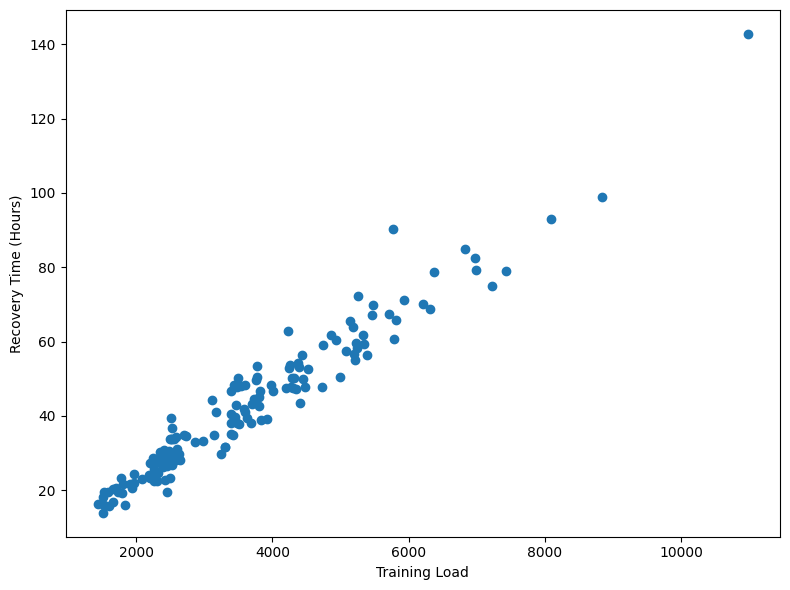

In [53]:
plt.figure(figsize=(8, 6))
plt.scatter(df['Training Load'], df['Recovery_time(Hours)'])

plt.xlabel('Training Load')
plt.ylabel('Recovery Time (Hours)')
plt.tight_layout()
plt.show()
